In [50]:
import sys
import numpy as np
from collections import OrderedDict
import pandas as pd
import numpy as np
import us

import bokeh.plotting as bk
from bokeh.models.glyphs import Patches, Line, Circle
from bokeh.models import (
    GMapPlot, Range1d, ColumnDataSource, LinearAxis,
    HoverTool, PanTool, WheelZoomTool, BoxSelectTool, ResetTool, PreviewSaveTool,
    GMapOptions,
    NumeralTickFormatter, PrintfTickFormatter)
from bokeh.resources import CDN
from bokeh.embed import components, autoload_static, autoload_server

In [51]:
## Read in information about current veteran population per congressional district
vets_orig=pd.read_excel("/Users/kschles/Documents/bokeh/veterans/10L_VetPop2014.xlsx")
## Trim down to current day stats
vets=vets_orig.loc[np.where(vets_orig['Date']=='2013-09-30')[0]]

In [52]:
## File that matches up each full state name with abbreviated two letter nickname
abbrev=pd.read_table('veterans/state_abbrev.txt', names=['state', 'nickname', 'short', 'capital'])

In [53]:
## Read in the population per CD from American Fact Finder data 
aff_pop=pd.read_csv('veterans/aff_download/ACS_12_1YR_S0101_with_ann.csv', skiprows=1)

In [54]:
## Read in file with information about legislators 
legislators=pd.read_csv('veterans/legislators-current.csv')

## Trim it down to representatives only (no senators)
reps=legislators.loc[np.where(legislators['type']=='rep')[0]]
reps.reset_index(drop=True, inplace=True)

Each of these use their own system for organising district identifiers. We put them all on a single system, where a district is identified by XX-YY, where XX is the two letter code for the state, and YY is a two digit number representing the district. If there is only a single district in the whole state, rather than a number YY is 'AL'

In [55]:
aff_pop['dnum']=aff_pop['Id'].str[-2:]
aff_pop['dstate']=aff_pop['Geography'].str.split(',').str[1].str.lstrip()

state_abbrev=[]
district_id=[]

for i in range(0,len(aff_pop)):
    temp=aff_pop.loc[i,'dstate']
    if ((temp!='District of Columbia') & (temp!='Puerto Rico')):
        #print temp
        shorter=abbrev.loc[np.where(abbrev['state']==temp)[0],'short']
        state_abbrev.append(np.array(shorter)[0])
        if (aff_pop.loc[i,'dnum']=="00"): 
            district_id.append(np.array(shorter)[0]+'-AL')
        if (aff_pop.loc[i,'dnum']!="00"): 
            district_id.append(np.array(shorter)[0]+'-'+aff_pop.loc[i,'dnum'].zfill(2))
    else: 
        district_id.append('None')

                               
aff_pop['district_id']=np.array(district_id)

In [56]:
cd_num1=vets['Congressional District (CD)'].str.split(' ').str[1]
cd_num2=cd_num1.str.replace('at', 'AL')
cd_num=cd_num2.str.replace('(', '')

state_abbrev=[]
district_id=[]
for i in range(0,len(vets)):
    temp=vets.loc[i,'State']
    if ((temp!='District of Columbia') & (temp!='Puerto Rico')):
        #print temp
        shorter=abbrev.loc[np.where(abbrev['state']==temp)[0],'short']
        state_abbrev.append(np.array(shorter)[0])
        district_id.append(np.array(shorter)[0]+'-'+cd_num[i].zfill(2))
    else : 
        district_id.append('None')

vets['district_id']=district_id

In [57]:
reps['district_id']=None 
reps['full_name']=None
for i in range(0,len(reps)): 
    dname=reps.loc[i,'state']+'-'+reps.loc[i,'district'].astype(int).astype(str).zfill(2)
    if (reps.loc[i,'district']==0.): 
        dname=reps.loc[i,'state']+'-AL'
    reps.loc[i,'district_id']=dname
    reps.loc[i,'full_name']=reps.loc[i,'first_name']+' '+reps.loc[i, 'last_name']

In [58]:
## The veteran population information is currently split by various parameters (Age, gender). We sum it below:
sum_by_dist=vets.groupby('district_id', as_index=False).sum()

In [59]:
## We merge the veteran population information with the data on the congressional district as a whole
combo1=pd.merge(sum_by_dist, aff_pop, how='left', on='district_id')

In [61]:
## Next, we merge in the information about the representative
combo=pd.merge(combo1, reps, how='left', on='district_id')

In [62]:
combo['pop_per']=100.*combo['Veteran']/combo['Total; Estimate; Total population']

In [63]:
combo[['district_id', 'pop_per', 'full_name', 'state']].sort('pop_per', ascending=False)
test=combo[['district_id', 'pop_per', 'full_name', 'state']].groupby('state', as_index=False).mean()
test.reset_index(drop=True, inplace=True)
print test.sort('pop_per', ascending=False)[0:5]

print test.sort('pop_per', ascending=True)[0:5]

   state    pop_per
0     AK  10.022437
25    MT   9.963745
20    ME   9.729527
44    VA   9.517006
48    WV   9.096037
   state   pop_per
33    NY  4.732054
4     CA  4.995788
30    NJ  5.013908
43    UT  5.344056
13    IL  5.738948


States with the highest mean percentage of veterans: Maine, Virginia, West Virginia, Oklahoma, Washington 

States with the smallest mean percentage of veterans: New York, California, New Jersey, Utah, Illinois 

In [104]:
cdnames = combo['district_id'].tolist()
percentage = combo['pop_per'].tolist()
representative = combo['full_name'].tolist()
party = combo['party'].tolist()

maxper = np.amax(percentage, axis=0)
minper = np.amin(percentage, axis=0)


In [95]:
cdnames = []
cd_data = {}
percentage = [] ; representative_orig = [] ; state = []
with open('veterans/district_info.csv', 'r') as f:
    for row in f:
        cdname = row.split(',')[0]
        cdnames.append(cdname)
        cd_data[cdname] = [x for x in row.split(',')[1:]]
        percentage.append(float(cd_data[cdname][0]))
        representative_orig.append(cd_data[cdname][1])
        state.append(cd_data[cdname][2])

maxper = np.amax(percentage, axis=0)
minper = np.amin(percentage, axis=0)
#filenames = ["/Users/kschles/Downloads/"+name+".dat" for name in boroughsnames]


In [105]:
from bokeh.palettes import Blues9
colors = ['#ffffff']+Blues9[::-1]

numcolors = len(colors)
color_vals = []
#perstep = (sorted(combo['pop_per'])[-2]-min(combo['pop_per']))/(numcolors-1)

maxpop = np.amax(percentage)
minpop = np.amin(percentage)
popstep = (maxpop-minpop)/(numcolors-1)
"""
for i in range(0,len(combo)):
    try:
        if (combo.loc[i,'district_id']!='None'): 
            pernorm = float(combo.loc[i,'pop_per']) - min(combo['pop_per'])
            idx = int(pernorm/perstep)
            color_vals.append(colors[idx])
    except KeyError:
        color_vals.append("black")
"""
for name in cdnames:
    try:
        popnorm = float(cd_data[name][0]) - minpop
        idx = int(popnorm/popstep)
        color_vals.append(colors[idx])
    except KeyError:
        color_vals.append("black")



In [134]:
## Read in information about district geography (lat/lon)
districts_orig=pd.read_csv('veterans/2012USCongressionalDistricts.csv')
districts=districts_orig.sort(['C_STATE', 'C_DIST_ID'])
districts.reset_index(drop=True, inplace=True)
districts.rename(columns={'SS-NN': 'district_id'}, inplace=True)

big_lat = [] 
big_lon = []

for j in range(0,30): 
    indexer=np.where(districts['district_id']==cdnames[j])[0]
    temp_dist=districts['geometry'][indexer[0]].split(' ')
    lat=[]
    lon=[]

    for i in range(0,len(temp_dist)):
        temp_dist[i]=temp_dist[i].replace('<Polygon><outerBoundaryIs><LinearRing><coordinates>', '')
        temp_dist[i]=temp_dist[i].replace('<MultiGeometry>', '')
        temp=temp_dist[i].split(',')
        if (i!=0): 
            ## Problem with certain districts having peculiar lay outs. Adding in nan to help 
            ## with plotting layout
            if ((abs(float(temp[1])-lon[i-1])>0.15) & (abs(float(temp[0])-lat[i-1])>0.15)):
                lat.append(np.nan)
                lon.append(np.nan)
        lat.append(float(temp[0]))
        lon.append(float(temp[1]))

    big_lat.append(lat)
    big_lon.append(lon)


    


In [23]:
"""
## Read in information about district geography (lat/lon)
districts_orig=pd.read_csv('veterans/2012USCongressionalDistricts.csv')
districts=districts_orig.sort(['C_STATE', 'C_DIST_ID'])
districts.reset_index(drop=True, inplace=True)
districts.rename(columns={'SS-NN': 'district_id'}, inplace=True)

big_lat = [] 
big_lon = []

for i in xrange(len(boroughsnames)):
    coords = np.genfromtxt(filenames[i])[:,:2]
    listofcoords.append(coords)
boroughs_xs = [coord[:,0].tolist() for coord in listofcoords]
boroughs_ys = [coord[:,1].tolist() for coord in listofcoords]

for j in range(len(cdnames)): 
    indexer=np.where(districts['district_id']==cdnames[j])[0]
    print indexer
    
    if (combo.loc[j,'district_id']!='None'): 
        temp_dist=combo['geometry'][j].split(' ')
        lat=[]
        lon=[]

        for i in range(0,len(temp_dist)):
            temp_dist[i]=temp_dist[i].replace('<Polygon><outerBoundaryIs><LinearRing><coordinates>', '')
            temp_dist[i]=temp_dist[i].replace('<MultiGeometry>', '')
            temp=temp_dist[i].split(',')
            if (i!=0): 
                ## Problem with certain districts having peculiar lay outs. Adding in nan to help 
                ## with plotting layout
                if ((abs(float(temp[1])-lon[i-1])>0.15) & (abs(float(temp[0])-lat[i-1])>0.15)):
                    lat.append(np.nan)
                    lon.append(np.nan)
            lat.append(float(temp[0]))
            lon.append(float(temp[1]))

        big_lat.append(lat)
        big_lon.append(lon)

"""

NameError: name 'boroughsnames' is not defined

In [146]:
temp_dist

['177.445931,52.111333,0.0',
 '177.44656,52.114453,0.0',
 '177.446228,52.12115,0.0',
 '177.446838,52.12716,0.0',
 '177.445983,52.13513,0.0',
 '177.44247,52.141455,0.0',
 '177.43792,52.146873,0.0',
 '177.43173,52.15224,0.0',
 '177.42577,52.157203,0.0',
 '177.41805,52.16213,0.0',
 '177.408835,52.167632,0.0',
 '177.400228,52.170501,0.0',
 '177.39824,52.170909,0.0',
 '177.391346,52.172331,0.0',
 '177.386706,52.17363,0.0',
 '177.38365,52.174276,0.0',
 '177.38048,52.17453,0.0',
 '177.3723,52.174925,0.0',
 '177.367356,52.1753,0.0',
 '177.36032,52.174034,0.0',
 '177.35203,52.17265,0.0',
 '177.34053,52.170323,0.0',
 '177.3293,52.166669,0.0',
 '177.315409,52.160976,0.0',
 '177.306009,52.15611,0.0',
 '177.2963,52.149867,0.0',
 '177.28883,52.14419,0.0',
 '177.28361,52.13849,0.0',
 '177.28181,52.13513,0.0',
 '177.28016,52.127579,0.0',
 '177.28135,52.11984,0.0',
 '177.28349,52.11416,0.0',
 '177.286448,52.108932,0.0',
 '177.28821,52.10643,0.0',
 '177.2906,52.10215,0.0',
 '177.298048,52.0958,0.0',
 '1

In [171]:
import pysal

In [172]:
shp=pysal.open('/Users/kschles/Downloads/districtShapes/districts114.shp')

In [163]:
indexer=np.where(districts['district_id']=='AK-AL')[0]
temp_dist=districts['geometry'][indexer[0]].split(' ')
lat=[]
lon=[]
for i in range(0,len(temp_dist)):
    temp_dist[i]=temp_dist[i].replace("<MultiGeometry><Polygon><outerBoundaryIs><LinearRing><coordinates>", "")
    temp_dist[i]=temp_dist[i].replace("<MultiGeometry>", "")
    temp=temp_dist[i].split(',')
    if (i!=0): 
        ## Problem with certain districts having peculiar lay outs. Adding in nan to help 
        ## with plotting layout
        if ((abs(float(temp[1])-lon[i-1])>0.15) & (abs(float(temp[0])-lat[i-1])>0.15)):
            lat.append(np.nan)
            lon.append(np.nan)
    lat.append(float(temp[0]))
    lon.append(float(temp[1]))




In [167]:
#indexer=np.where(districts['district_id']=='AK-AL')[0]
#temp_dist=districts['geometry'][indexer[0]].split(' ')

print temp_dist[51]
print temp_dist[52]

177.445931,52.111333,0.0</coordinates></LinearRing></outerBoundaryIs></Polygon><Polygon><outerBoundaryIs><LinearRing><coordinates>178.044883,51.821497,0.0
178.066398,51.827204,0.0


(-200, -100)

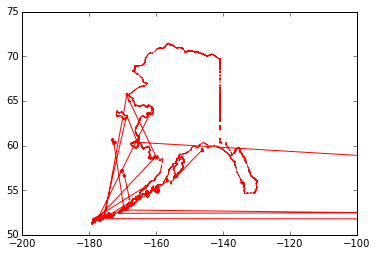

In [143]:
import matplotlib.pyplot as plt 
%matplotlib inline 

plt.plot(big_lat[0], big_lon[0], 'r-')
plt.xlim(-200,-100)

In [135]:
bk.output_file('test.html')

In [136]:
source = bk.ColumnDataSource(data=dict( boroughsnames=cdnames,
                               percentage=percentage, representative=representative))

p = GMapPlot(title="", 
             plot_width=900, plot_height=700,
             x_range = Range1d(), y_range = Range1d(),
             map_options=GMapOptions(lat=64.2, lng=-149.50, zoom=4))
p.map_options.map_type="roadmap" # satellite, roadmap, terrain or hybrid


In [137]:
source_patches = bk.ColumnDataSource(data=dict( boroughs_xs=big_lat, boroughs_ys=big_lon,
                                                boroughs_colors=color_vals,
                                                boroughsnames=cdnames,
                                                percentage=percentage, 
                                                representative=representative))


patches = Patches(xs='boroughs_xs', ys='boroughs_ys', fill_color='boroughs_colors',
                  fill_alpha=0.5, line_color="black", line_width=0.5)
patches_glyph = p.add_glyph(source_patches, patches)



In [138]:
p.add_tools(PanTool(), WheelZoomTool(), HoverTool(), 
            ResetTool(), PreviewSaveTool())

In [139]:
hover = p.select(dict(type=HoverTool))
hover.tooltips = OrderedDict([
    ("District", "@boroughsnames"),
    ("Veteran Percentage", "@percentage"),
    ("Representative", "@representative"),
])


In [140]:
bk.show(p)